In [28]:
# Time Series Prediction with GRU
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from pickle import dump

In [29]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return numpy.array(dataX), numpy.array(dataY)

In [30]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [31]:
dataset_name = "lanh-su-quan-hoa-ky-hcm"
product_name = "pm25"
file_path = 'dataset/data-pm2.5-lanh-su-quan-hcm-20160211-20211203.csv'
dataframe = pd.read_csv(file_path)
dataframe['date'] = pd.to_datetime(dataframe.date, format='%Y-%m-%d', errors='coerce')
dataframe = dataframe.sort_values(by='date') 
print("Dataframe: \n", dataframe)
dataset = numpy.asarray(dataframe[product_name]).reshape(-1,1)
print("MIN=", dataset.min(),"MAX=", dataset.max(),"AVG=", dataset.mean())
print("Dataset: \n", dataset)


Dataframe: 
            date  pm25
1970 2016-02-11    68
1971 2016-02-12    54
1972 2016-02-13    54
1973 2016-02-14    54
1974 2016-02-15    59
...         ...   ...
32   2021-11-30    57
0    2021-12-01    86
1    2021-12-02   109
2    2021-12-03    90
2020 2021-12-04   106

[2021 rows x 2 columns]
MIN= 5 MAX= 222 AVG= 77.16674913409203
Dataset: 
 [[ 68]
 [ 54]
 [ 54]
 ...
 [109]
 [ 90]
 [106]]


In [32]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print("Dataset after scale: \n", dataset)

Dataset after scale: 
 [[0.29032258]
 [0.22580645]
 [0.22580645]
 ...
 [0.47926267]
 [0.39170507]
 [0.46543779]]


In [33]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [34]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print("TrainX shape: ", trainX.shape)
print("TrainY shape: ", trainY.shape)

TrainX shape:  (1412, 1)
TrainY shape:  (1412,)


In [35]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [36]:
# create and fit the GRU network
model = Sequential()
# model.add(GRU(4, input_shape=(1, look_back), return_sequences=True))
model.add(GRU(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
history = model.fit(trainX, trainY, epochs=1000, batch_size=10, verbose=2,
          validation_data=(testX, testY))

score = model.evaluate(testX, testY, verbose=0)
print('score: test score = ', score)

# save the model
model.save('models/rnn-GRU-'+product_name)
# save the scaler
dump(scaler, open('models/rnn-GRU-'+product_name+'/scaler.pkl', 'wb'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 4)                 84        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
142/142 - 3s - loss: 0.0180 - val_loss: 0.0065
Epoch 2/1000
142/142 - 1s - loss: 0.0066 - val_loss: 0.0060
Epoch 3/1000
142/142 - 1s - loss: 0.0063 - val_loss: 0.0057
Epoch 4/1000
142/142 - 0s - loss: 0.0060 - val_loss: 0.0056
Epoch 5/1000
142/142 - 1s - loss: 0.0058 - val_loss: 0.0055
Epoch 6/1000
142/142 - 1s - loss: 0.0056 - val_loss: 0.0053
Epoch 7/1000
142/142 - 1s - loss: 0.0055 - val_loss: 0.0055
Epoch 8/1000
142/142 - 0s - loss: 0.0054 - val_loss: 0.0050
Epoch 9/1000
142/142 - 1s - loss: 0

INFO:tensorflow:Assets written to: models/rnn-GRU-pm25/assets


INFO:tensorflow:Assets written to: models/rnn-GRU-pm25/assets


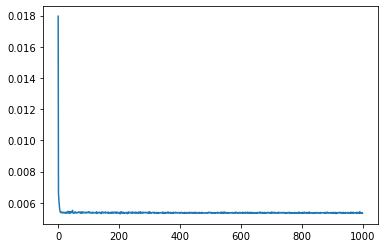

In [37]:
plt.plot(history.history['loss'])

In [38]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [39]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

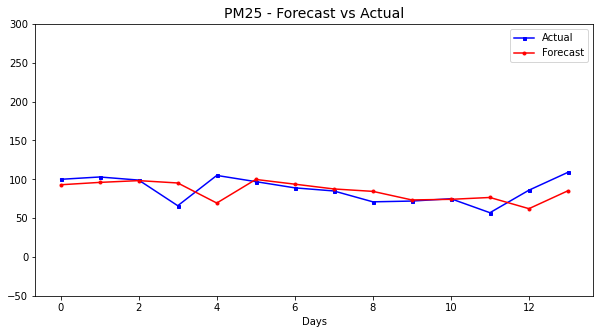

In [40]:
test_Y = testY[0][len(testY[0])-15:len(testY[0])-1]
test_Ypred = testPredict[len(testPredict)-15:len(testPredict)-1]
plt.subplots(figsize=(10, 5))
plt.title(product_name.upper() + " - Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(numpy.ravel(test_Y)), "bs-", markersize=3, label="Actual")
plt.plot(pd.Series(numpy.ravel(test_Ypred)), "ro-", markersize=3, label="Forecast")
plt.legend(loc="best")
plt.xlabel("Days")
plt.ylim([-50,300])
plt.show()

In [41]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.8f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.8f RMSE' % (testScore))

Train Score: 15.82516055 RMSE
Test Score: 15.22619676 RMSE


In [42]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [43]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

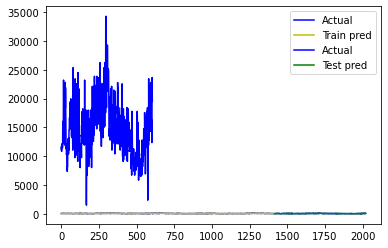

In [44]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),"b-", label="Actual")
plt.plot(trainPredictPlot,"y-", label="Train pred")
plt.plot(scaler.inverse_transform(testY)[0],"b-", label="Actual")
plt.plot(testPredictPlot, "g-", label="Test pred")
plt.legend(loc="best")
# plt.ylim([-0.02,0.02])
plt.show()